In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification

In [6]:
# Custom Dataset Class
class DiabetesRetinopathyDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = datasets.ImageFolder(root_dir)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Training Function
def train_vision_transformer(data_dir, epochs=20, learning_rate=1e-4):
    # Set Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Data Transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Load Dataset
    full_dataset = DiabetesRetinopathyDataset(data_dir, transform=transform)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    
    # Model Initialization
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224', 
        num_labels=5,  # 5 classes of diabetic retinopathy
        ignore_mismatched_sizes=True
    )
    
    # Modify the classifier to match the number of classes
    model.classifier = nn.Linear(model.config.hidden_size, 5)
    model = model.to(device)
    
    # Optimizer, Loss, and Scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    
    # Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Transfer to GPU/CPU
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # Print Epoch Summary
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Training Loss: {total_loss/len(train_loader):.4f}')
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')
        
        # Step the scheduler
        scheduler.step()
    
    # Save the Trained Model
    torch.save(model.state_dict(), 'diabetic_retinopathy_vit.pth')
    print("Model saved as 'diabetic_retinopathy_vit.pth'")
    
    return model

In [7]:
model = train_vision_transformer('/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images')

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
Training Loss: 0.6977
Validation Accuracy: 77.63%
Epoch 2/20
Training Loss: 0.5450
Validation Accuracy: 79.26%
Epoch 3/20
Training Loss: 0.4719
Validation Accuracy: 80.35%
Epoch 4/20
Training Loss: 0.4060
Validation Accuracy: 82.81%
Epoch 5/20
Training Loss: 0.3890
Validation Accuracy: 80.63%
Epoch 6/20
Training Loss: 0.3660
Validation Accuracy: 81.58%
Epoch 7/20
Training Loss: 0.3044
Validation Accuracy: 80.90%
Epoch 8/20
Training Loss: 0.2688
Validation Accuracy: 81.31%
Epoch 9/20
Training Loss: 0.2205
Validation Accuracy: 77.22%
Epoch 10/20
Training Loss: 0.1989
Validation Accuracy: 80.22%
Epoch 11/20
Training Loss: 0.0892
Validation Accuracy: 81.72%
Epoch 12/20
Training Loss: 0.0561
Validation Accuracy: 83.08%
Epoch 13/20
Training Loss: 0.0511
Validation Accuracy: 81.86%
Epoch 14/20
Training Loss: 0.0476
Validation Accuracy: 82.13%
Epoch 15/20
Training Loss: 0.0385
Validation Accuracy: 81.86%
Epoch 16/20
Training Loss: 0.0382
Validation Accuracy: 82.26%
Epoch 17/20
Train

In [8]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Custom Dataset Class (same as for ViT)
class DiabetesRetinopathyDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = datasets.ImageFolder(root_dir)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Custom CNN Model Definition
class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=4, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Flatten and fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 25 * 25, 32)
        self.dropout = nn.Dropout(0.15)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        # First block
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        
        # Second block
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        
        # Third block
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        
        # Flatten and fully connected
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Training Function for CNN
def train_custom_cnn(data_dir, epochs=50, learning_rate=1e-5, batch_size=16):
    # Set Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data Transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Load Dataset
    full_dataset = DiabetesRetinopathyDataset(data_dir, transform=transform)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Model Initialization
    model = CustomCNN(num_classes=5)  # 5 classes of diabetic retinopathy
    model = model.to(device)
    
    # Optimizer, Loss, and Scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    # Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        # Use tqdm for progress tracking
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)  # Transfer to GPU/CPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Update progress bar
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        model.eval()
        correct, total = 0, 0
        val_loss = 0
        
        # Use tqdm for validation progress
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
        
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar
                current_acc = (predicted == labels).sum().item() / labels.size(0)
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.4f}'})
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        # Print Epoch Summary
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        
        # Step the scheduler
        scheduler.step()
    
    # Save the Trained Model
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, 'diabetic_retinopathy_cnn.pth')
    
    print("Model saved as 'diabetic_retinopathy_cnn.pth'")
    
    return model, history

In [10]:
data_dir='/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images'

In [11]:
cnn_model, cnn_history = train_custom_cnn(data_dir, epochs=20)

Using device: cuda


Epoch 1/20 [Val]: 100%|██████████| 46/46 [00:03<00:00, 13.98it/s, loss=0.7513, acc=0.6923]


Epoch 1/20
Training Loss: 1.0657
Validation Loss: 0.9606
Validation Accuracy: 65.48%


Epoch 2/20 [Val]: 100%|██████████| 46/46 [00:03<00:00, 12.53it/s, loss=0.7021, acc=0.7692]


Epoch 2/20
Training Loss: 0.8743
Validation Loss: 0.9091
Validation Accuracy: 67.94%


Epoch 3/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 18.67it/s, loss=0.6024, acc=0.7692]


Epoch 3/20
Training Loss: 0.8206
Validation Loss: 0.8695
Validation Accuracy: 66.98%


Epoch 4/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 18.77it/s, loss=0.5470, acc=0.7692]


Epoch 4/20
Training Loss: 0.7896
Validation Loss: 0.8384
Validation Accuracy: 67.53%


Epoch 5/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 19.57it/s, loss=0.5429, acc=0.8462]


Epoch 5/20
Training Loss: 0.7932
Validation Loss: 0.8135
Validation Accuracy: 68.89%


Epoch 6/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 19.97it/s, loss=0.5668, acc=0.7692]


Epoch 6/20
Training Loss: 0.7657
Validation Loss: 0.8075
Validation Accuracy: 69.44%


Epoch 7/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 18.71it/s, loss=0.5318, acc=0.9231]


Epoch 7/20
Training Loss: 0.7597
Validation Loss: 0.8049
Validation Accuracy: 69.03%


Epoch 8/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 19.75it/s, loss=0.4486, acc=0.9231]


Epoch 8/20
Training Loss: 0.7469
Validation Loss: 0.7957
Validation Accuracy: 69.03%


Epoch 9/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 19.92it/s, loss=0.5375, acc=0.8462]


Epoch 9/20
Training Loss: 0.7359
Validation Loss: 0.7945
Validation Accuracy: 70.67%


Epoch 10/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 18.88it/s, loss=0.4465, acc=0.8462]


Epoch 10/20
Training Loss: 0.7262
Validation Loss: 0.7761
Validation Accuracy: 70.67%


Epoch 11/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 20.03it/s, loss=0.4706, acc=0.7692]


Epoch 11/20
Training Loss: 0.7078
Validation Loss: 0.7801
Validation Accuracy: 70.53%


Epoch 12/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 20.33it/s, loss=0.4830, acc=0.8462]


Epoch 12/20
Training Loss: 0.7105
Validation Loss: 0.7819
Validation Accuracy: 71.21%


Epoch 13/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 18.95it/s, loss=0.4950, acc=0.8462]


Epoch 13/20
Training Loss: 0.6960
Validation Loss: 0.7785
Validation Accuracy: 71.08%


Epoch 14/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 18.87it/s, loss=0.4778, acc=0.7692]


Epoch 14/20
Training Loss: 0.7050
Validation Loss: 0.7774
Validation Accuracy: 70.94%


Epoch 15/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 20.37it/s, loss=0.4719, acc=0.8462]


Epoch 15/20
Training Loss: 0.7051
Validation Loss: 0.7746
Validation Accuracy: 71.76%


Epoch 16/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 18.78it/s, loss=0.4974, acc=0.8462]


Epoch 16/20
Training Loss: 0.7123
Validation Loss: 0.7800
Validation Accuracy: 71.35%


Epoch 17/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 19.77it/s, loss=0.4766, acc=0.7692]


Epoch 17/20
Training Loss: 0.7059
Validation Loss: 0.7769
Validation Accuracy: 71.35%


Epoch 18/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 19.89it/s, loss=0.4875, acc=0.7692]


Epoch 18/20
Training Loss: 0.7094
Validation Loss: 0.7766
Validation Accuracy: 71.62%


Epoch 19/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 18.79it/s, loss=0.4940, acc=0.7692]


Epoch 19/20
Training Loss: 0.7042
Validation Loss: 0.7749
Validation Accuracy: 72.31%


Epoch 20/20 [Val]: 100%|██████████| 46/46 [00:02<00:00, 19.28it/s, loss=0.4994, acc=0.7692]

Epoch 20/20
Training Loss: 0.6946
Validation Loss: 0.7789
Validation Accuracy: 70.94%
Model saved as 'diabetic_retinopathy_cnn.pth'


In [12]:
cnn_model

CustomCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=20000, out_features=32, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (fc2): Linear(in_features=32, out_features=5, bias=True)
)

In [15]:
class HybridEnsemble:
    def __init__(self, cnn_model, vit_model, device):
        self.cnn_model = cnn_model
        self.vit_model = vit_model
        self.device = device
        
        # Set models to evaluation mode
        self.cnn_model.eval()
        self.vit_model.eval()
    
    def predict(self, x):
        """Get class predictions (argmax of probabilities)"""
        probs = self.predict_proba(x)
        _, predicted_classes = torch.max(probs, 1)
        return predicted_classes
    
    def predict_proba(self, x):
        """Get averaged class probabilities from both models"""
        # Make sure input is on the correct device
        x = x.to(self.device)
        
        # Get probabilities from CNN model
        with torch.no_grad():
            cnn_outputs = self.cnn_model(x)
            cnn_probs = torch.softmax(cnn_outputs, dim=1)
        
        # Get probabilities from ViT model
        with torch.no_grad():
            vit_outputs = self.vit_model(x).logits
            vit_probs = torch.softmax(vit_outputs, dim=1)
        
        # Average the probabilities
        avg_probs = (cnn_probs + vit_probs) / 2
        
        return avg_probs

# Function to create and evaluate the hybrid ensemble
def create_and_evaluate_hybrid_ensemble(data_dir, cnn_model, vit_model, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create the hybrid ensemble using the passed models
    ensemble = HybridEnsemble(cnn_model, vit_model, device)
    
    # Prepare test dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    test_dataset = DiabetesRetinopathyDataset(data_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Evaluate models (CNN, ViT, and Ensemble)
    models = {
        'CNN': cnn_model,
        'ViT': vit_model,
        'Ensemble': ensemble
    }
    
    results = {}
    all_probs = {}
    
    # Class names
    class_names = test_dataset.dataset.classes if hasattr(test_dataset.dataset, 'classes') else [f'Class {i}' for i in range(5)]
    
    for model_name, model_obj in models.items():
        print(f"\nEvaluating {model_name}...")
        all_labels = []
        all_preds = []
        all_probs[model_name] = []
        
        test_pbar = tqdm(test_loader, desc=f"Testing {model_name}")
        
        with torch.no_grad():
            for images, labels in test_pbar:
                images = images.to(device)
                
                if model_name == 'CNN':
                    outputs = model_obj(images)
                    probs = torch.softmax(outputs, dim=1)
                    _, predicted = torch.max(outputs, 1)
                elif model_name == 'ViT':
                    outputs = model_obj(images).logits
                    probs = torch.softmax(outputs, dim=1)
                    _, predicted = torch.max(outputs, 1)
                else:  # Ensemble
                    probs = model_obj.predict_proba(images)
                    predicted = model_obj.predict(images)
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs[model_name].extend(probs.cpu().numpy())
                
                # Update progress bar
                test_pbar.set_postfix({'batch': f'{len(all_labels)}'})
        
        # Calculate accuracy
        accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
        results[model_name] = {
            'accuracy': accuracy,
            'predictions': all_preds,
            'labels': all_labels
        }
        
        print(f"{model_name} Accuracy: {accuracy:.2f}%")
    
    
    
    return ensemble, results

# Modified run_hybrid_ensemble_pipeline function to use existing models
def run_hybrid_ensemble_pipeline(data_dir, cnn_model, vit_model):
    # Create and evaluate hybrid ensemble with existing models
    ensemble, results = create_and_evaluate_hybrid_ensemble(
        data_dir, 
        cnn_model, 
        vit_model
    )
    
    return ensemble, results
# Function to plot training histories



In [17]:
def visualize_ensemble_metrics(results, all_probs, class_names):
    """
    Visualize performance metrics for the ensemble model only
    
    Args:
        results: Dictionary containing evaluation results
        all_probs: Dictionary containing prediction probabilities
        class_names: List of class names
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from sklearn.metrics import (
        confusion_matrix, classification_report, roc_curve, auc,
        precision_recall_curve, average_precision_score, recall_score, 
        precision_score, f1_score, accuracy_score
    )
    import pandas as pd
    from itertools import cycle
    
    # Get ensemble predictions and labels
    ensemble_preds = results['Ensemble']['predictions']
    ensemble_labels = results['Ensemble']['labels']
    
    # 1. Confusion Matrix for Ensemble
    cm = confusion_matrix(ensemble_labels, ensemble_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Ensemble Model Confusion Matrix')
    plt.savefig('ensemble_confusion_matrix.png')
    plt.show()
    
    # 2. Classification Report for Ensemble
    report = classification_report(ensemble_labels, ensemble_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    print("\nEnsemble Classification Report:")
    print(pd.DataFrame(report_df).round(3))
    
    # Calculate specificity for each class
    specificities = []
    
    for i in range(len(class_names)):
        # Convert to binary for this class
        true_binary = np.array(ensemble_labels) == i
        pred_binary = np.array(ensemble_preds) == i
        
        # True negative rate (specificity) = TN / (TN + FP)
        tn = np.sum((~true_binary) & (~pred_binary))
        fp = np.sum((~true_binary) & pred_binary)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    # Create a dataframe with metrics for each class
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': [precision_score(ensemble_labels, ensemble_preds, labels=[i], average=None)[0] for i in range(len(class_names))],
        'Recall': [recall_score(ensemble_labels, ensemble_preds, labels=[i], average=None)[0] for i in range(len(class_names))],
        'Specificity': specificities,
        'F1-Score': [f1_score(ensemble_labels, ensemble_preds, labels=[i], average=None)[0] for i in range(len(class_names))]
    })
    
    print("\nDetailed Metrics by Class:")
    print(metrics_df.round(3))
    
    # Overall accuracy
    accuracy = accuracy_score(ensemble_labels, ensemble_preds)
    print(f"\nOverall Accuracy: {accuracy:.3f}")
    
    # 3. ROC Curves for Ensemble (multiclass)
    n_classes = len(class_names)
    ensemble_probs = np.array(all_probs['Ensemble'])
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(12, 10))
    
    y_true = np.array(ensemble_labels)
    y_score = ensemble_probs
    
    for i in range(n_classes):
        # One-vs-rest approach
        y_true_binary = (y_true == i).astype(int)
        y_score_binary = y_score[:, i]
        
        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score_binary)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
    
    # Compute micro-average ROC curve and ROC area
    y_true_onehot = np.zeros((len(y_true), n_classes))
    y_true_onehot[np.arange(len(y_true)), y_true] = 1
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves for Ensemble Model')
    plt.legend(loc="lower right")
    plt.savefig('ensemble_roc_curves.png')
    plt.show()
    
  
    plt.figure(figsize=(12, 10))
    
    # For each class
    precision = {}
    recall = {}
    avg_precision = {}
    
    for i in range(n_classes):
        y_true_binary = (y_true == i).astype(int)
        y_score_binary = y_score[:, i]
        
        precision[i], recall[i], _ = precision_recall_curve(y_true_binary, y_score_binary)
        avg_precision[i] = average_precision_score(y_true_binary, y_score_binary)
        
        plt.plot(recall[i], precision[i], lw=2,
                 label=f'Class {class_names[i]} (AP = {avg_precision[i]:.2f})')
    
    # Compute micro-average precision-recall curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_true_onehot.ravel(), y_score.ravel())
    avg_precision["micro"] = average_precision_score(
        y_true_onehot.ravel(), y_score.ravel())
    
    # Plot micro-average precision-recall curve
    plt.plot(recall["micro"], precision["micro"], 
             label=f'Micro-average Precision-Recall (AP = {avg_precision["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Ensemble Model')
    plt.legend(loc="best")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.savefig('ensemble_precision_recall_curves.png')
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'classification_report': report_df,
        'specificities': specificities,
        'roc_auc': roc_auc,
        'precision_recall_avg_precision': avg_precision
    }

# Updated create_and_evaluate_hybrid_ensemble function to include ensemble metrics
def create_and_evaluate_hybrid_ensemble(data_dir, cnn_model, vit_model, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    
    ensemble = HybridEnsemble(cnn_model, vit_model, device)
    
    # Prepare test dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    test_dataset = DiabetesRetinopathyDataset(data_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Evaluate models (CNN, ViT, and Ensemble)
    models = {
        'CNN': cnn_model,
        'ViT': vit_model,
        'Ensemble': ensemble
    }
    
    results = {}
    all_probs = {}
    
    # Class names
    class_names = test_dataset.dataset.classes if hasattr(test_dataset.dataset, 'classes') else [f'Class {i}' for i in range(5)]
    
    for model_name, model_obj in models.items():
        print(f"\nEvaluating {model_name}...")
        all_labels = []
        all_preds = []
        all_probs[model_name] = []
        
        test_pbar = tqdm(test_loader, desc=f"Testing {model_name}")
        
        with torch.no_grad():
            for images, labels in test_pbar:
                images = images.to(device)
                
                if model_name == 'CNN':
                    outputs = model_obj(images)
                    probs = torch.softmax(outputs, dim=1)
                    _, predicted = torch.max(outputs, 1)
                elif model_name == 'ViT':
                    outputs = model_obj(images).logits
                    probs = torch.softmax(outputs, dim=1)
                    _, predicted = torch.max(outputs, 1)
                else:  # Ensemble
                    probs = model_obj.predict_proba(images)
                    predicted = model_obj.predict(images)
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs[model_name].extend(probs.cpu().numpy())
                
                # Update progress bar
                test_pbar.set_postfix({'batch': f'{len(all_labels)}'})
        
        # Calculate accuracy
        accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
        results[model_name] = {
            'accuracy': accuracy,
            'predictions': all_preds,
            'labels': all_labels
        }
        
        print(f"{model_name} Accuracy: {accuracy:.2f}%")
    
    # Only visualize metrics for the ensemble model
    print("\n=== Ensemble Model Metrics ===")
    metrics = visualize_ensemble_metrics(results, all_probs, class_names)
    
    return ensemble, results, metrics

# Modified run_hybrid_ensemble_pipeline function to return metrics
def run_hybrid_ensemble_pipeline(data_dir, cnn_model, vit_model):
    # Create and evaluate hybrid ensemble with existing models
    ensemble, results, metrics = create_and_evaluate_hybrid_ensemble(
        data_dir, 
        cnn_model, 
        vit_model
    )
    
    return ensemble, results, metrics

Using device: cuda

Evaluating CNN...


Testing CNN: 100%|██████████| 229/229 [00:10<00:00, 20.93it/s, batch=3662]


CNN Accuracy: 74.44%

Evaluating ViT...


Testing ViT: 100%|██████████| 229/229 [00:31<00:00,  7.19it/s, batch=3662]


ViT Accuracy: 95.47%

Evaluating Ensemble...


Testing Ensemble: 100%|██████████| 229/229 [00:53<00:00,  4.24it/s, batch=3662]


Ensemble Accuracy: 95.47%

=== Ensemble Model Metrics ===


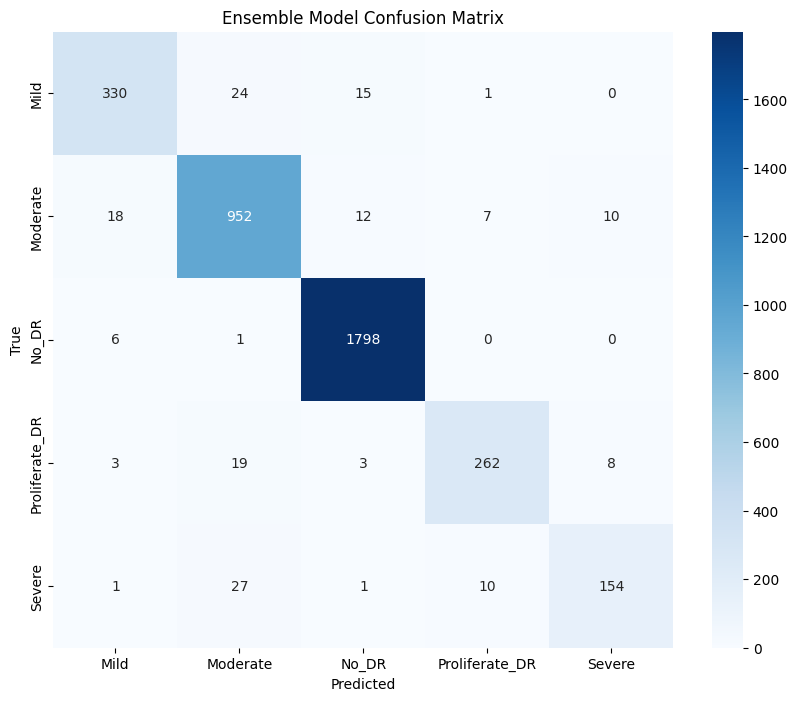


Ensemble Classification Report:
                precision  recall  f1-score   support
Mild                0.922   0.892     0.907   370.000
Moderate            0.931   0.953     0.942   999.000
No_DR               0.983   0.996     0.990  1805.000
Proliferate_DR      0.936   0.888     0.911   295.000
Severe              0.895   0.798     0.844   193.000
accuracy            0.955   0.955     0.955     0.955
macro avg           0.933   0.905     0.919  3662.000
weighted avg        0.954   0.955     0.954  3662.000

Detailed Metrics by Class:
            Class  Precision  Recall  Specificity  F1-Score
0            Mild      0.922   0.892        0.991     0.907
1        Moderate      0.931   0.953        0.973     0.942
2           No_DR      0.983   0.996        0.983     0.990
3  Proliferate_DR      0.936   0.888        0.995     0.911
4          Severe      0.895   0.798        0.995     0.844

Overall Accuracy: 0.955


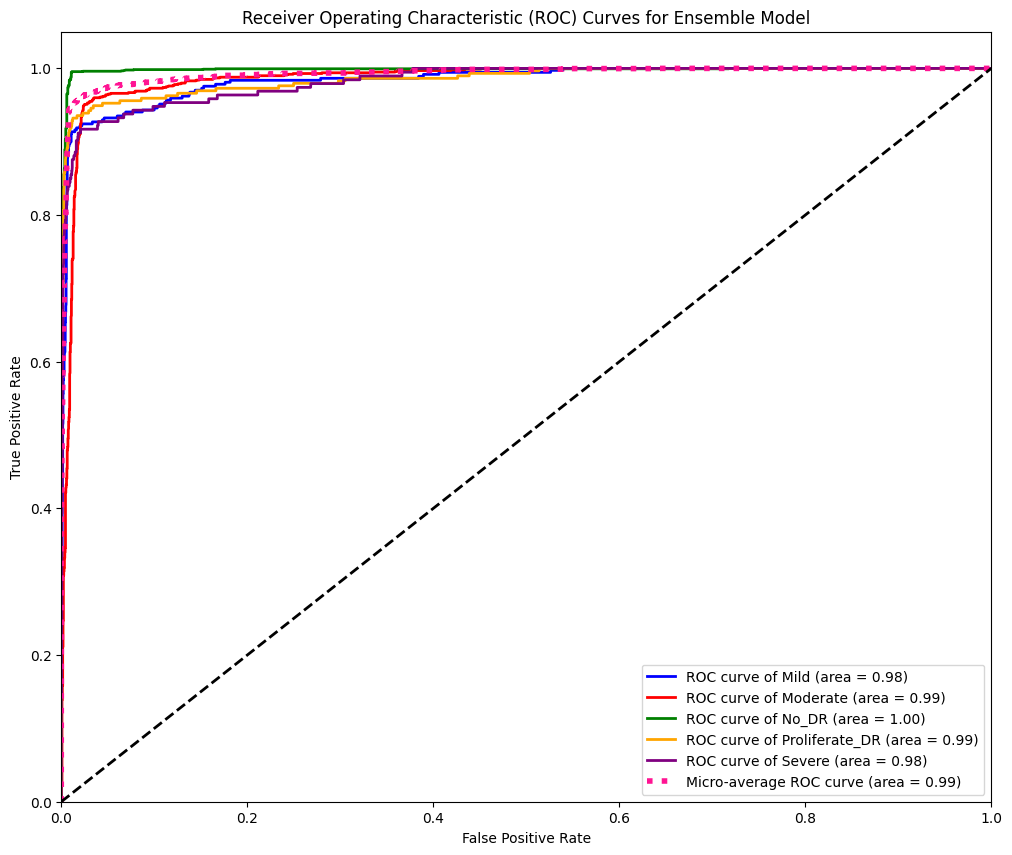

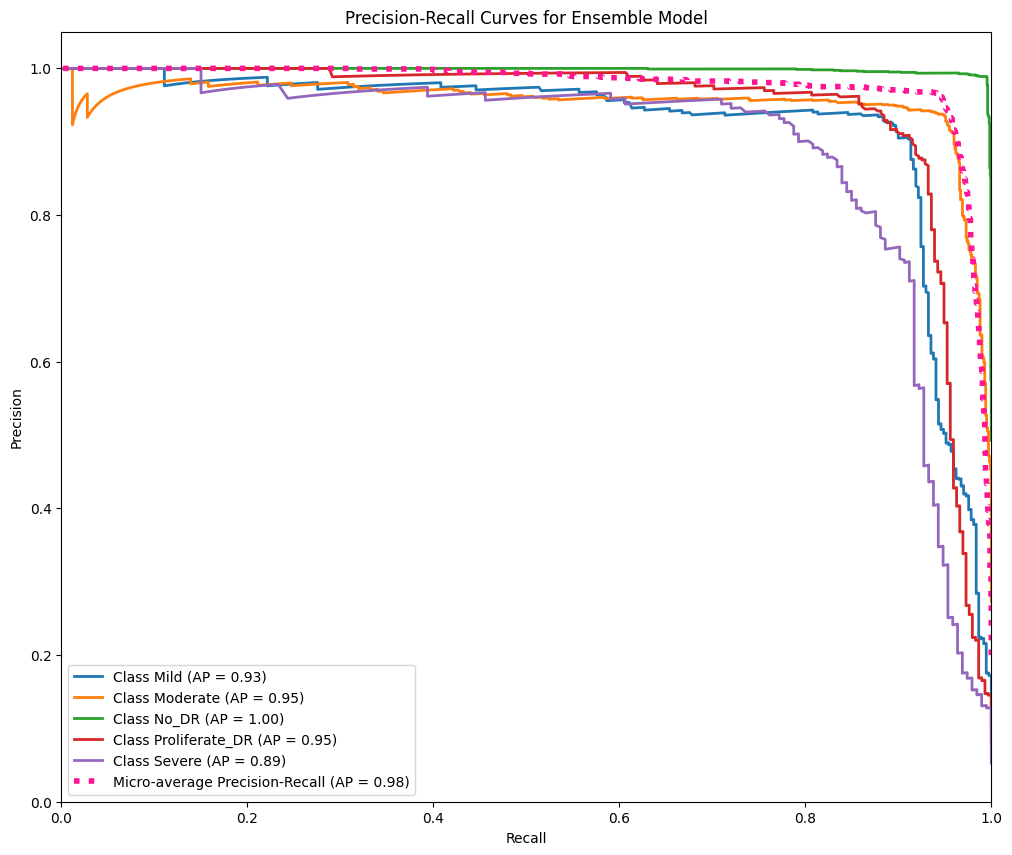

Complete!


In [18]:
data_dir = "/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images"
ensemble, results, metrics = run_hybrid_ensemble_pipeline(data_dir, cnn_model, model)
print("Complete!")

In [19]:
!zip -r file.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/ensemble_roc_curves.png (deflated 13%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/diabetic_retinopathy_cnn.pth (deflated 9%)
  adding: kaggle/working/diabetic_retinopathy_vit.pth (deflated 7%)
  adding: kaggle/working/ensemble_precision_recall_curves.png (deflated 11%)
  adding: kaggle/working/ensemble_confusion_matrix.png (deflated 17%)


In [20]:
from IPython.display import FileLink 
FileLink(r'file.zip')

/kaggle/working/file.zip